## Prediksi Penyakit Jantung dengan XgBoost
### Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning.space import Integer, Real

## Import Datasets

In [2]:
df = pd.read_csv("../Datasets/heart.csv")

In [3]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Simple EDA and Data Preprocessing

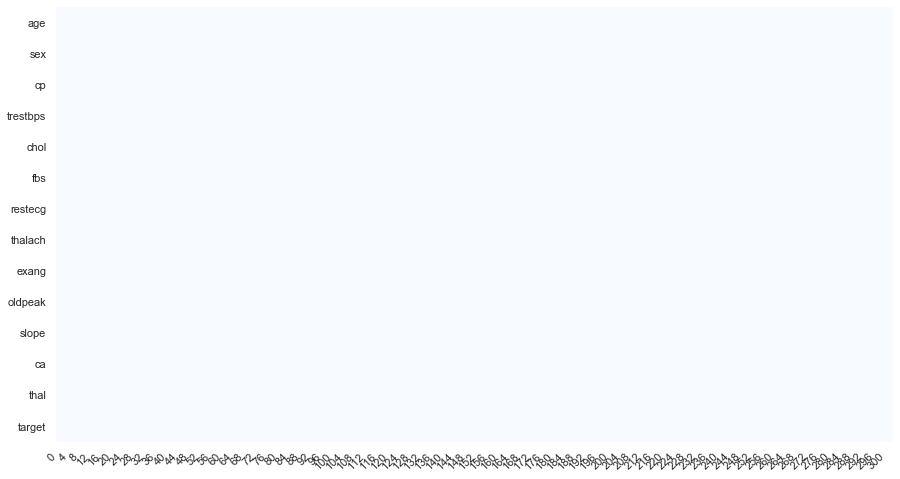

In [5]:
plot_missing_value(df)

#### 1. Membersihkan Outlier

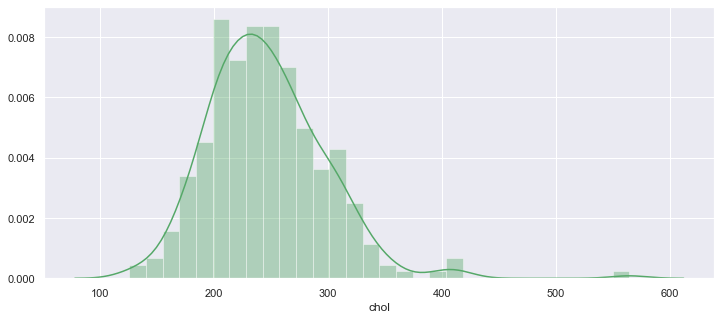

In [6]:
plt.figure(figsize=(12, 5))
ax = sns.distplot(df["chol"], bins=30, color='g')
plt.show()

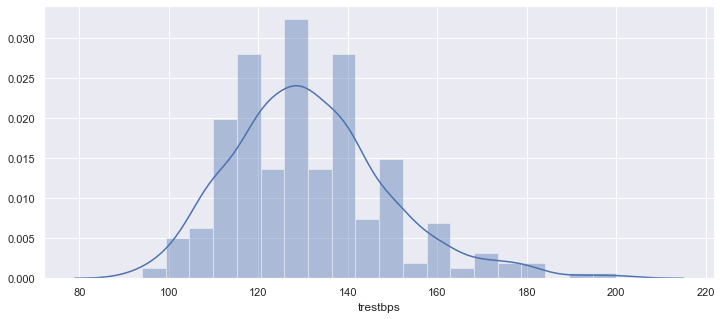

In [7]:
# Kolom trestbps
plt.figure(figsize=(12, 5))
ax = sns.distplot(df["trestbps"], bins=20)
plt.show()

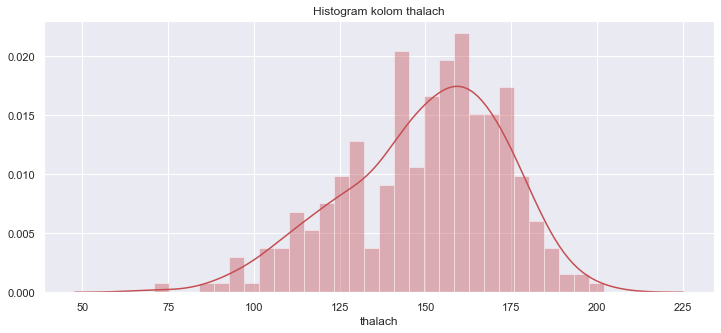

In [8]:
# Kolom thalach
plt.figure(figsize=(12, 5))
ax = sns.distplot(df["thalach"], bins=30, color='r')
plt.title("Histogram kolom thalach")
plt.show()

In [9]:
Q1 = df["chol"].quantile(0.25) #membuat Q1
Q3 = df["chol"].quantile(0.75) #membuat Q3

IQR = Q3 - Q1 #menghitung IQR
print(f"IQR = {IQR}\nQ1 = {Q1}\nQ3 = {Q3}")

batas_bawah = Q1-(1.5*IQR)
batas_atas = Q3+(1.5*IQR)

print(f"batas bawah: {batas_bawah}\nbatas atas: {batas_atas}")

IQR = 63.5
Q1 = 211.0
Q3 = 274.5
batas bawah: 115.75
batas atas: 369.75


In [10]:
df = df[(df["chol"]>=batas_bawah) & (df["chol"]<=batas_atas)] #filter outlier
df.reset_index(drop=True, inplace=True) #reset index

In [11]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
294,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
295,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
296,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


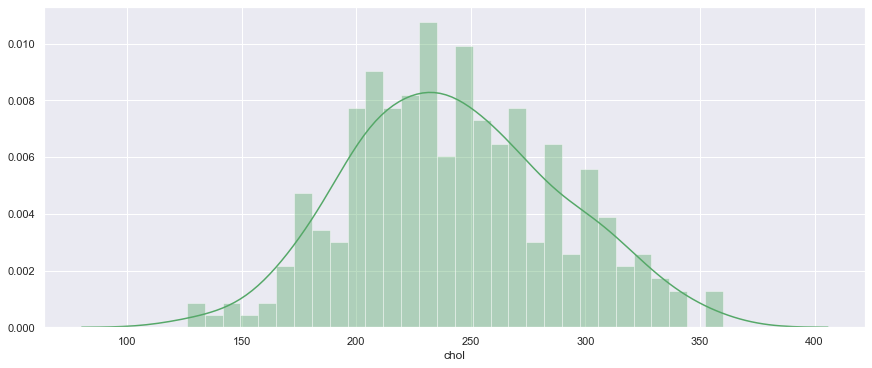

In [12]:
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
ax = sns.distplot(df["chol"], bins=30, color='g')
plt.show()

In [13]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,54.228188,0.694631,0.969799,131.553691,243.043624,0.147651,0.536913,149.546980,0.328859,1.025168,1.402685,0.721477,2.308725,0.543624
std,9.081836,0.461338,1.032678,17.612519,45.094679,0.355350,0.525748,23.079853,0.470589,1.156392,0.618671,1.018156,0.612983,0.498931
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,152.000000,0.000000,0.650000,1.000000,0.000000,2.000000,1.000000
75%,60.750000,1.000000,2.000000,140.000000,273.000000,0.000000,1.000000,166.750000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,360.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# EDA
## Simple EDA -> Target

In [14]:
df["target"].value_counts()

1    162
0    136
Name: target, dtype: int64

In [19]:
df["target"].value_counts(normalize=True)

1    0.543624
0    0.456376
Name: target, dtype: float64

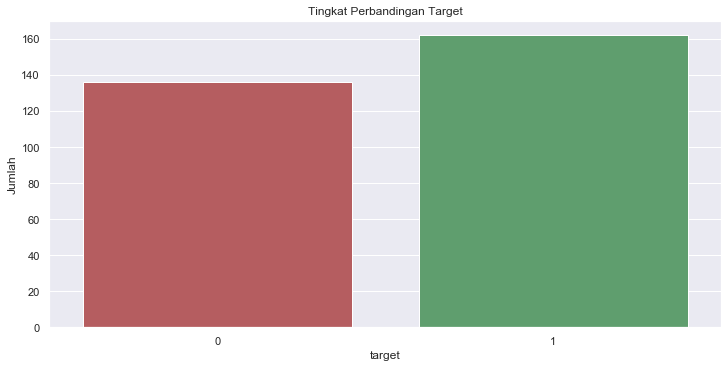

In [18]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
_  = ax.set_title("Tingkat Perbandingan Target")
_ = sns.countplot(x="target", data=df, palette=["r", "g"])
_ = ax.set_ylabel("Jumlah")
plt.show()

## Hubungan Data Numeric dan target

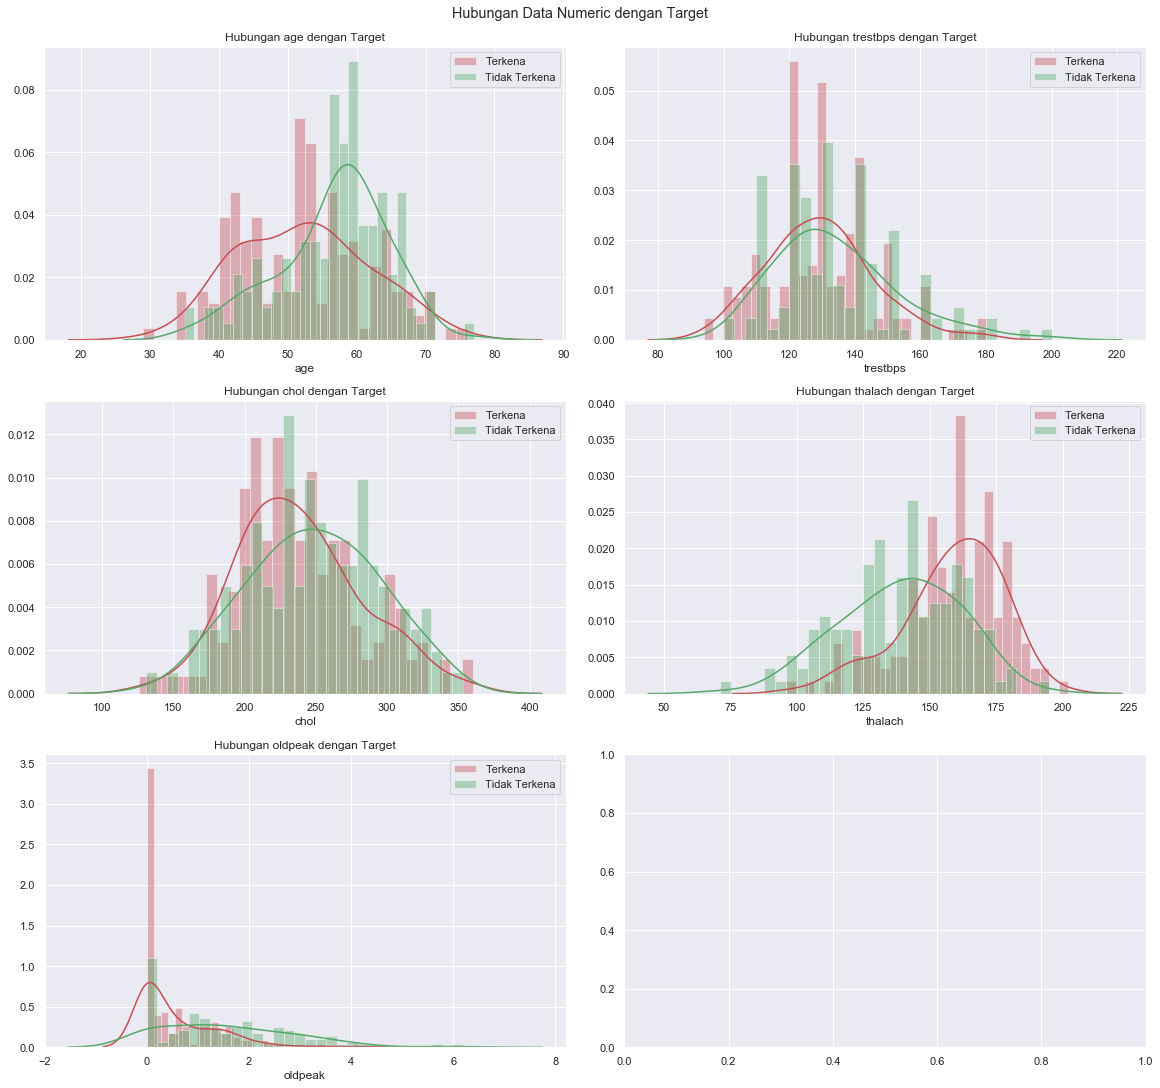

In [36]:
num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
fig, axes = plt.subplots(ncols=2, nrows=3, constrained_layout=True, figsize=(16, 15))
fig.suptitle("Hubungan Data Numeric dengan Target")
for kolom, ax in zip(num_cols, axes.flatten()):
    _ = ax.set_title(f"Hubungan {kolom} dengan Target")
    _ = sns.distplot(df[kolom][df["target"] == 1], bins=30, color="r", label="Terkena", ax=ax)
    _ = sns.distplot(df[kolom][df["target"] == 0], bins=30, color="g", label="Tidak Terkena", ax=ax)
    _ = ax.legend()
    
plt.show()

# Hubungan Data Categoric dengan Target

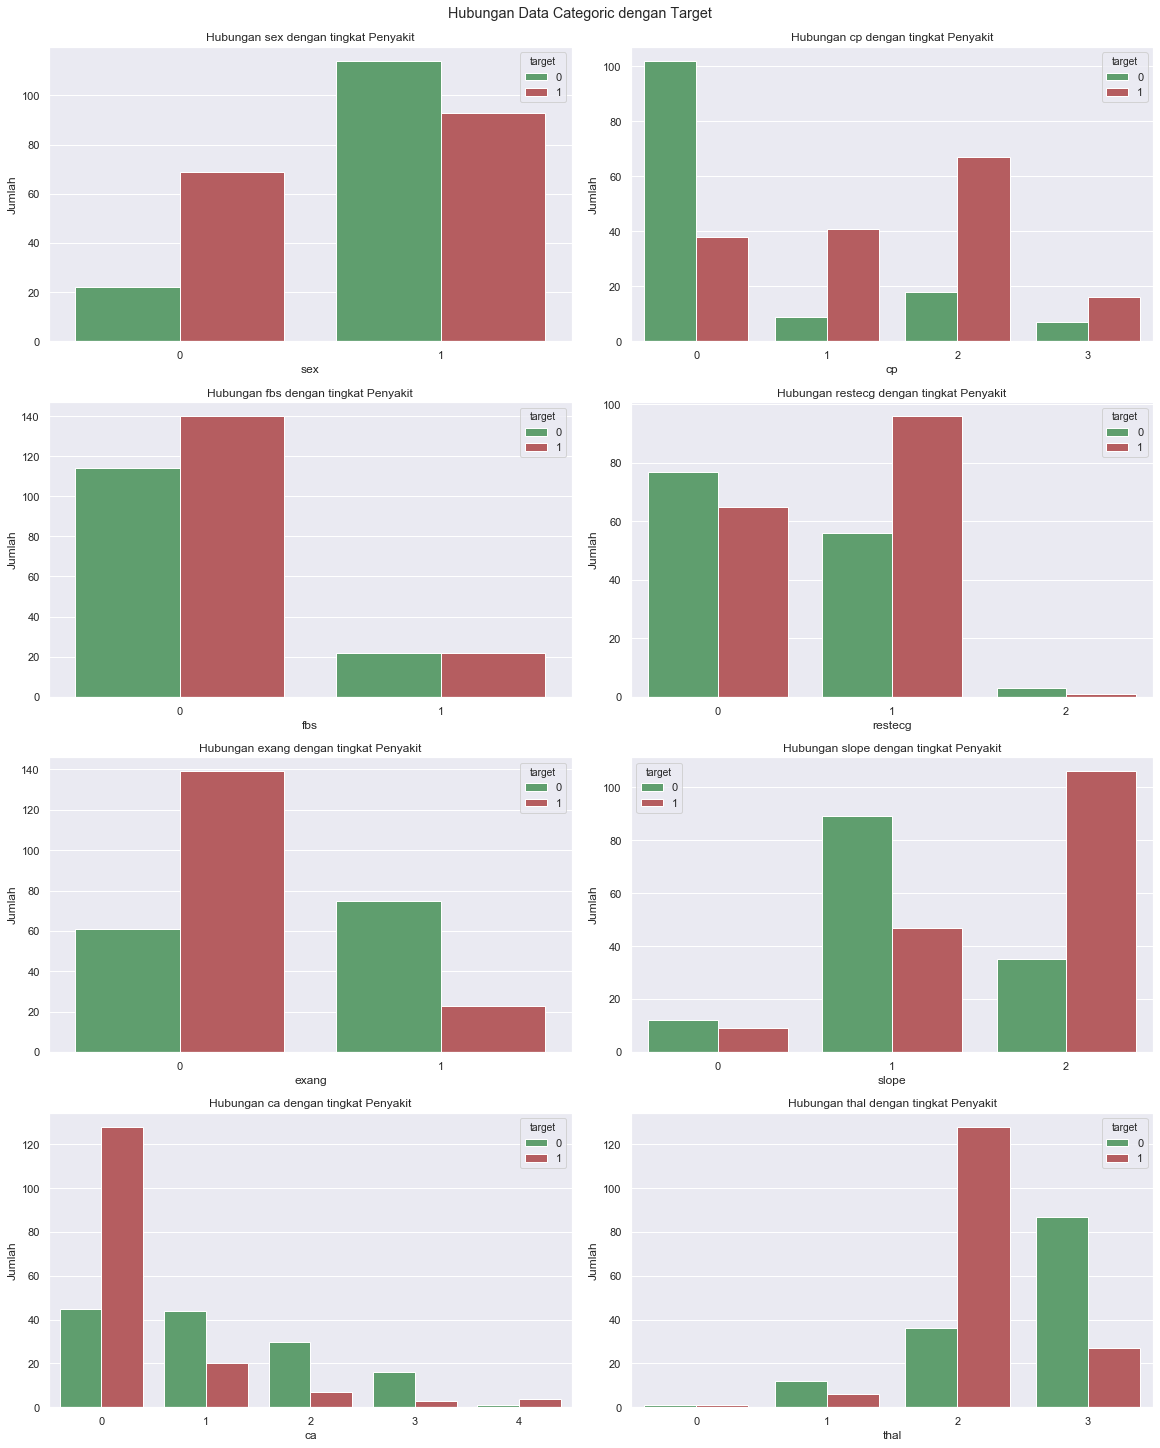

In [44]:
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

fig, axes = plt.subplots(ncols=2, nrows=4, constrained_layout=True, figsize=(16, 20))
fig.suptitle("Hubungan Data Categoric dengan Target")

for kolom, ax in zip(cat_cols, axes.flatten()):
    _ = ax.set_title(f"Hubungan {kolom} dengan tingkat Penyakit")
    _ = sns.countplot(x=kolom, data=df, hue="target", palette=["g", "r"], ax=ax)
    _ = ax.set_ylabel("Jumlah")
    
plt.show()

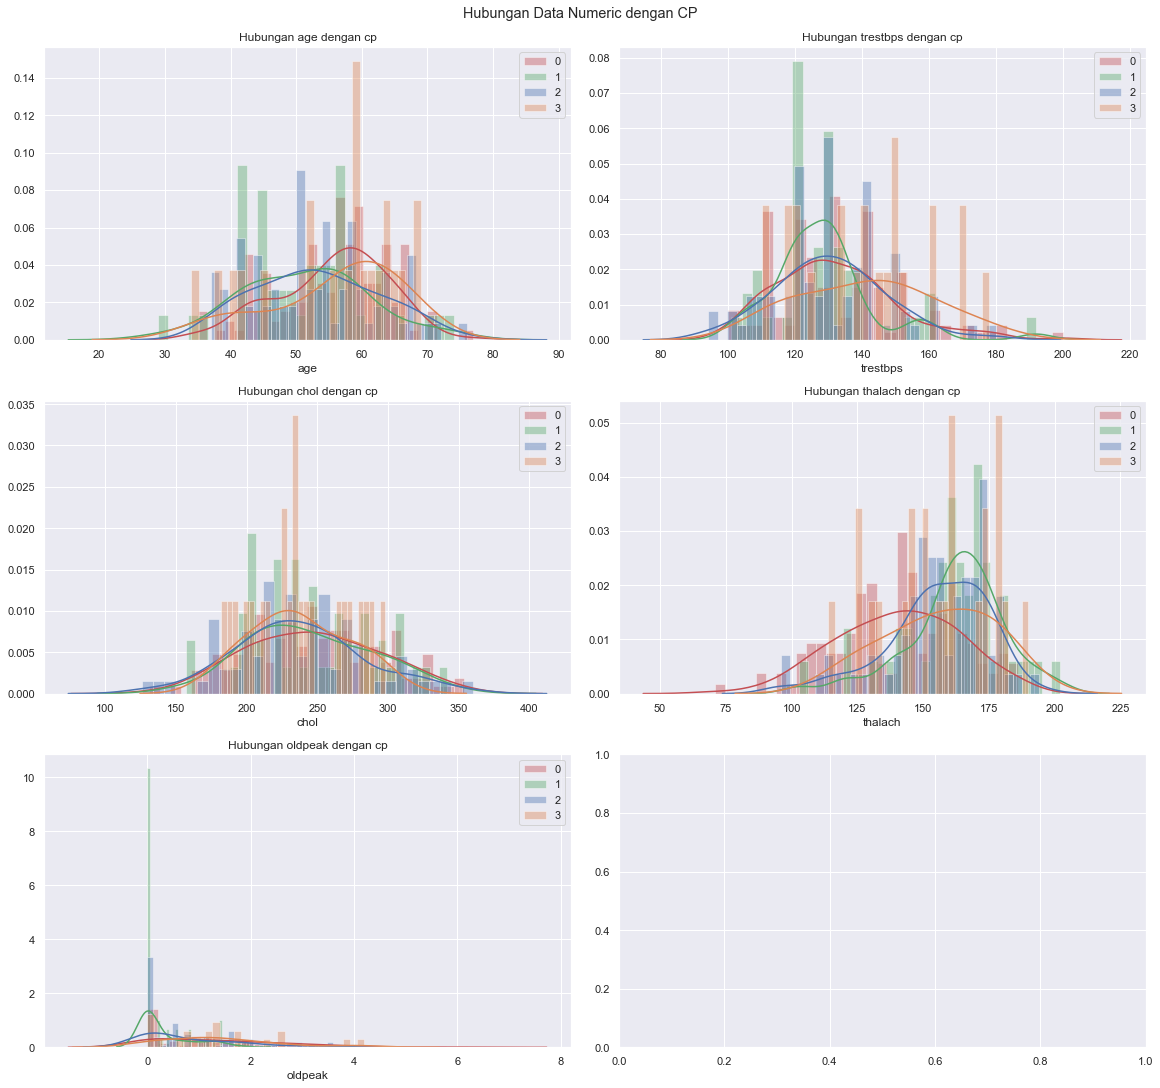

In [47]:
num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
fig, axes = plt.subplots(ncols=2, nrows=3, constrained_layout=True, figsize=(16, 15))
fig.suptitle("Hubungan Data Numeric dengan CP")
for kolom, ax in zip(num_cols, axes.flatten()):
    _ = ax.set_title(f"Hubungan {kolom} dengan cp")
    _ = sns.distplot(df[kolom][df["cp"] == 0], bins=30, color="r", label="0", ax=ax)
    _ = sns.distplot(df[kolom][df["cp"] == 1], bins=30, color="g", label="1", ax=ax)
    _ = sns.distplot(df[kolom][df["cp"] == 2], bins=30, label="2", ax=ax)
    _ = sns.distplot(df[kolom][df["cp"] == 3], bins=30, label="3", ax=ax)
    _ = ax.legend()
    
plt.show()

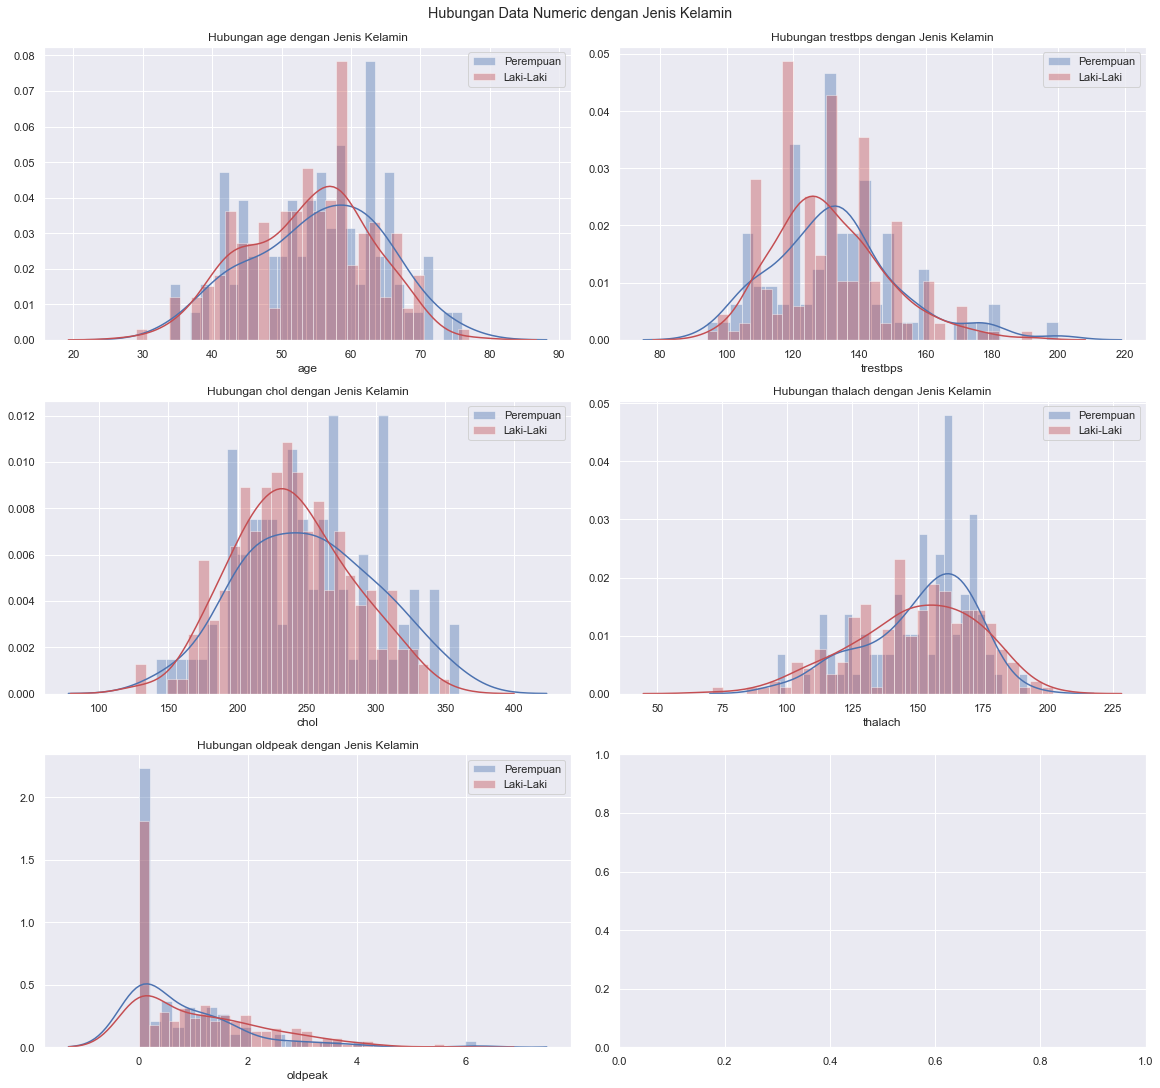

In [48]:
num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
fig, axes = plt.subplots(ncols=2, nrows=3, constrained_layout=True, figsize=(16, 15))
fig.suptitle("Hubungan Data Numeric dengan Jenis Kelamin")
for kolom, ax in zip(num_cols, axes.flatten()):
    _ = ax.set_title(f"Hubungan {kolom} dengan Jenis Kelamin")
    _ = sns.distplot(df[kolom][df["sex"] == 0], bins=30, color="b", label="Perempuan", ax=ax)
    _ = sns.distplot(df[kolom][df["sex"] == 1], bins=30, color="r", label="Laki-Laki", ax=ax)
    _ = ax.legend()
    
plt.show()

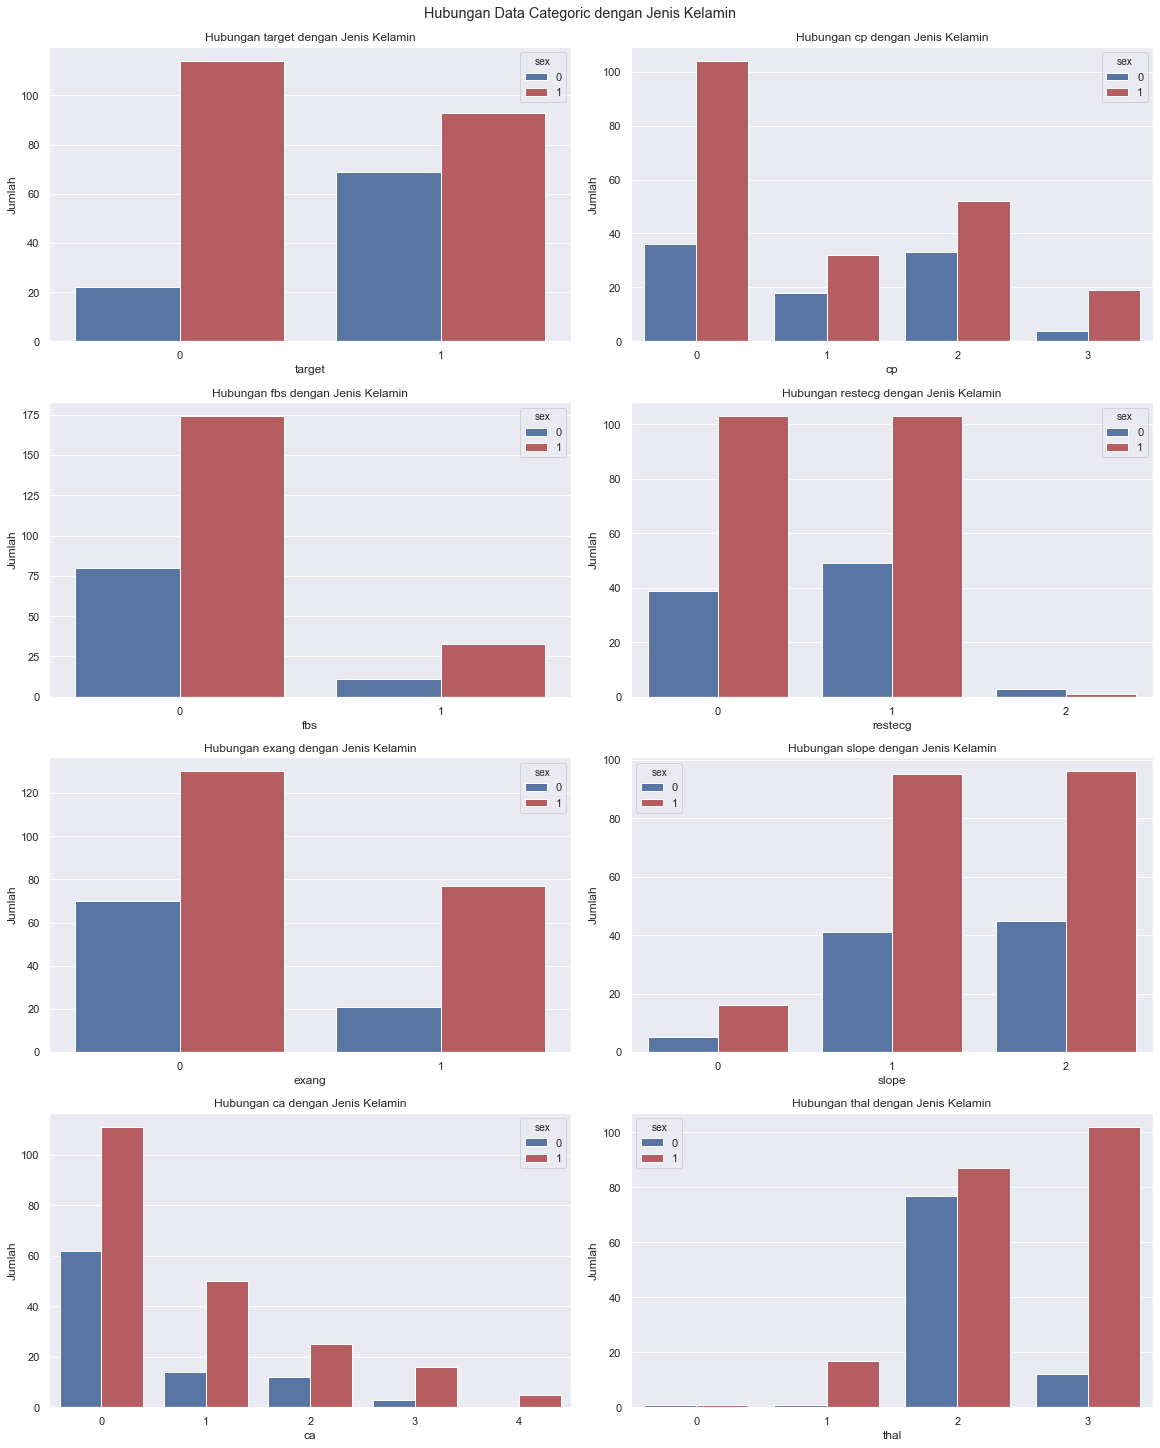

In [49]:
cat_cols = ["target", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

fig, axes = plt.subplots(ncols=2, nrows=4, constrained_layout=True, figsize=(16, 20))
fig.suptitle("Hubungan Data Categoric dengan Jenis Kelamin")

for kolom, ax in zip(cat_cols, axes.flatten()):
    _ = ax.set_title(f"Hubungan {kolom} dengan Jenis Kelamin")
    _ = sns.countplot(x=kolom, data=df, hue="sex", palette=["b", "r"], ax=ax)
    _ = ax.set_ylabel("Jumlah")
    
plt.show()